In [1]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import ROM, EDMD, DMD
import matplotlib.pyplot as plt
import scipy.interpolate as si


$$
\begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix} = \begin{pmatrix}
{v}(t)  \\
a u(t) + b u(t)^2 + c u(t)^3 + d(t)\\
\end{pmatrix}$$


## Creating the data

We first create the data by obtaining the solution ( snapshots) of $\pmb{y}$ through numerical integration using `scipy.integrate.solve_ivp` (MATLAB's `ode45`-like

In [2]:
def create_data(pres, freq=0):
    mass = 1000
    rigid = 1e7
    mu_coeff = 6
    mu = mu_coeff * rigid / 0.2
    A = 1
    pres_init0 = 1e5
    Ls0 = 1.2
    L0 = 1
    p = lambda t : pres * np.sin(2 * np.pi * freq * t)

    a_ = rigid;
    b_ = mu;
    c_ = A * pres_init0;
    interm = (((np.sqrt((27 * b_ * c_**2 + 4 * a_**3) / b_)) / (b_ * 2 * 3**(3. / 2.))) - c_ / (2 * b_))**(1. / 3.);
    u0 = interm - a_ / (3 * b_ * interm);

    a = -rigid/mass - 3*mu*(u0**2)/mass
    b = 3*mu*u0/mass
    c = -mu/mass
    d = lambda t : (u0**3)*mu/mass + rigid * u0/mass + A * p(t) / mass 
    v_dot = lambda u, t : c * u**3 + b * u**2 + a * u + d(t)

    ntt = 600
    dt = 6e-4
    input_t = np.arange(ntt)*dt

    from scipy.integrate import solve_ivp
    def f(t, y): return np.array([y[1], v_dot(y[0], t)])
    sol = solve_ivp(f, [0, input_t[-1]], np.array([(Ls0 - L0), 0]), t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t,dt, v_dot

input_data, input_t, dt, v_dot = create_data(1e6)

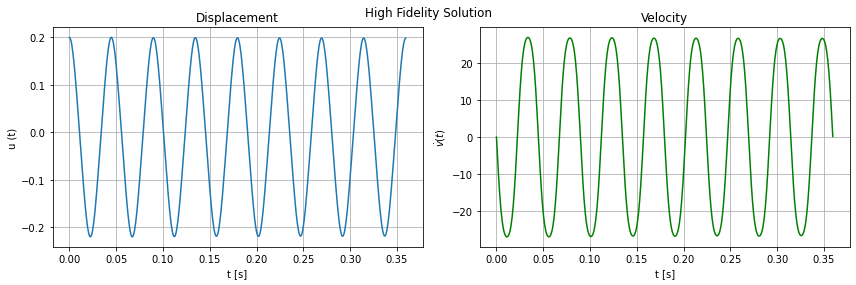

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(input_t, input_data[0, :],);
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("u (t)");
ax[0].set_title("Displacement");

ax[1].plot(input_t, input_data[1, :], 'g');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel(r"$\dot{v} (t)$");
ax[1].set_title("Velocity");

plt.tight_layout();
fig.suptitle("High Fidelity Solution");

**Organizing training data**

In [4]:
Coeff = 0.7
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

X = np.vstack((X, X**2, X**3, np.ones((1, X.shape[1]))))
Y = v_dot(Y, train_t)

#observables = [lambda x : x, lambda x : x**2, lambda x : x**3,]

In [5]:
rank = 0
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, rank =rank,)

In [6]:
pred_t = input_t.copy()
pred = np.zeros((1, pred_t.shape[0]))

for i in range(pred.shape[1]):
    pred[:, i] = edmd.A @ np.array([input_data[0, i], input_data[0, i]**2, input_data[0, i]**3, 1])

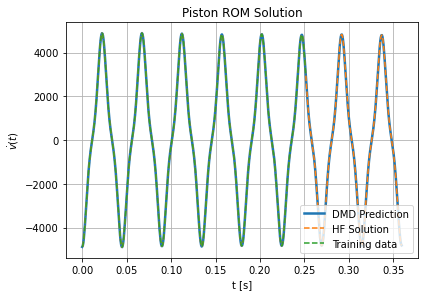

In [7]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, Y[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title("Piston ROM Solution"); 

In [8]:
input_data, input_t, dt, v_dot = create_data(1e6, 16)

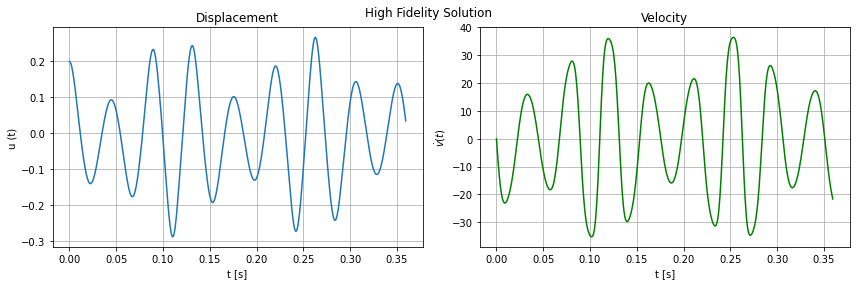

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(input_t, input_data[0, :],);
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("u (t)");
ax[0].set_title("Displacement");

ax[1].plot(input_t, input_data[1, :], 'g');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel(r"$\dot{v} (t)$");
ax[1].set_title("Velocity");

plt.tight_layout();
fig.suptitle("High Fidelity Solution");

In [10]:
Coeff = 0.7
train_data = input_data[:, :int(Coeff*input_data.shape[1])]
train_t = input_t[:int(Coeff*input_t.shape[0])]

test_data = input_data[:, int(Coeff*input_data.shape[1])::]
test_t = input_t[int(Coeff*input_t.shape[0])::]

X = train_data[:1, :].reshape((1, -1))
Y = train_data[:1, :].reshape((1, -1))

X = np.vstack((X, X**2, X**3, np.ones((1, X.shape[1]))))
Y = v_dot(Y, train_t)

#observables = [lambda x : x, lambda x : x**2, lambda x : x**3,]

In [11]:
rank = 0
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, rank =rank,)

In [12]:
pred_t = input_t.copy()
pred = np.zeros((1, pred_t.shape[0]))

for i in range(pred.shape[1]):
    pred[:, i] = edmd.A @ np.array([input_data[0, i], input_data[0, i]**2, input_data[0, i]**3, 1])

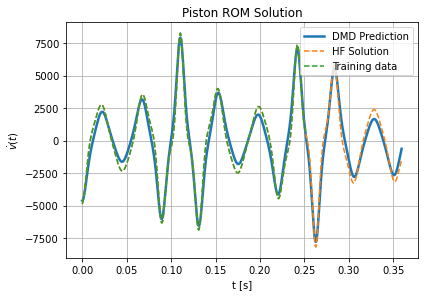

In [13]:
plt.plot(pred_t, pred[0, :], linewidth = 2.5, label = 'DMD Prediction');
plt.plot(input_t, v_dot(input_data[0, :], input_t), '--', label = 'HF Solution');
plt.plot(train_t, Y[0, :], '--', label = 'Training data');
plt.grid();
plt.ylabel(r"$\dot{v} (t)$");
plt.xlabel("t [s]");
plt.legend();
plt.tight_layout();
plt.title("Piston ROM Solution"); 